In [2]:
import tensorflow as tf
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import xlrd, xlwt
from pandas import DataFrame
import math

%matplotlib inline

'''
Класс, представляющий собой одну кинематическую пару
'''
class KinematicPart:
    s = tf.constant(0, dtype=tf.float32)
    a = tf.constant(0, dtype=tf.float32)
    alpha = tf.constant(0, dtype=tf.float32)
    
    borderMin = tf.constant(0, dtype=tf.float32)
    borderMax = tf.constant(0, dtype=tf.float32)
    
    def __init__(self, s,a,alpha, bmin, bmax):
        self.s = tf.constant(s, dtype=tf.float32)
        self.a = tf.constant(a, dtype=tf.float32)
        self.alpha = tf.constant(alpha, dtype=tf.float32)
        self.borderMin = tf.constant(bmin, dtype=tf.float32)
        self.borderMax = tf.constant(bmax, dtype=tf.float32)
        
    def getMatrix(self, q):
        return [
            [tf.cos(q), -tf.sin(q)*tf.cos(self.alpha), tf.sin(q)*tf.sin(self.alpha), self.a*tf.cos(q)],
            [tf.sin(q), tf.cos(q)*tf.cos(self.alpha), -tf.cos(q)*tf.sin(self.alpha), self.a*tf.sin(q)],
            [0, tf.sin(self.alpha), tf.cos(self.alpha), self.s],
            [0, 0, 0, 1]
                         ]


'''
Класс робота, состоящего из пар
'''
class Robot:
    parts = []
    penaltiesMin = None
    penaltiesMax = None
    
    def __init__(self, parts):
        self.parts = parts
        self.penaltiesMin = [(p.borderMin) for p in self.parts]
        self.penaltiesMax = [(p.borderMax) for p in self.parts]
    
    '''
    Получить значение штрафа для данных обобщенных координат
    '''
    def penalty(self, Q, W1=1, W2=1):
        
        reduce_to_nil = lambda n: tf.cond(n > 0,
                                         lambda:tf.constant(0,dtype=tf.float32), lambda:tf.abs(n))
        
        return W1*tf.reduce_sum(
            tf.map_fn(reduce_to_nil, tf.subtract(Q, self.penaltiesMin))
        ) + W2*tf.reduce_sum(tf.map_fn(reduce_to_nil, tf.subtract(self.penaltiesMax, Q)))
    
    
    '''
    Получить координаты схвата (конечного звена)
    '''
    def getXYZ(self, Q):
        return self.getXYZPair(Q, len(self.parts))[:3]
    
    '''
    Получить координаты конкретной пары 
    '''    
    def getXYZPair(self, Q, pair):
        
        resultMatrix = tf.eye(4, dtype=tf.float32)
        
        for i,p in enumerate(self.parts):
            
            if i==pair:
                break
            
            resultMatrix = tf.matmul(resultMatrix,p.getMatrix(Q[i]))
        
        xyz1 = tf.matmul(resultMatrix,tf.constant([[0],[0],[0],[1]], dtype=tf.float32))

        return xyz1
    
    
    '''
    Массив координат всех пар (для построения графика)
    '''
    def getPairPoints(self, Q):
        
        result = []
        
        for i,p in enumerate(self.parts):
            pairXYZ = self.getXYZPair(Q,i)
            result.append([pairXYZ[0],pairXYZ[1], pairXYZ[2]])
        
        return result

    

ModuleNotFoundError: No module named 'tensorflow'

In [1]:
# Сбросить вычислительный граф
tf.reset_default_graph()
r=np.pi/180.0

# 
Z1 = KinematicPart(675, 260, np.pi/2, bmin=-185*r, bmax=185*r)
Z2 = KinematicPart(0, 680, 0, bmin=50*r, bmax=270*r)
Z3 = KinematicPart(0, 35, 3*np.pi/2, bmin=-360*r, bmax=360*r)
Z4 = KinematicPart(670, 0, np.pi/2, bmin=90*r, bmax=90*r)
Z5 = KinematicPart(0, 0, 3*np.pi/2, bmin=-20*r, bmax=-30*r)
Z6 = KinematicPart(533.857843276, 59.861001834, 0, bmin=0*r, bmax=0*r)

parts = [Z1,Z2,Z3,Z4,Z5,Z6]

RV = Robot(parts)


NameError: name 'tf' is not defined

In [3]:
trajectory = [
     [[1105],[-245],[1100]],
     [[1105],[-245],[1000]],
     [[1105],[-245],[950]],
     [[1105],[-245],[900]],
     [[1105],[-245],[850]],
     [[1105],[-245],[800]],
     [[1105],[-245],[750]],
     [[1105],[-245],[700]],
     [[1105],[-245],[650]],
     [[1105],[-245],[600]],
     [[1105],[-245],[550]],
     [[1105],[-245],[505]]
]

In [9]:
Q0 = tf.Variable([-12.748*r, 112.644*r, -117.454*r, 90*r, 9.978*r, 0*r],dtype=tf.float32, name="Q_initial")

targetPlace = tf.placeholder(tf.float32, name="targetXYZ")
target = tf.Variable([[0],[0],[0]], dtype=tf.float32)
next_target = tf.assign(target, targetPlace)

xyz = RV.getXYZ(Q0)[:3]
penalty = RV.penalty(Q0, 9999, 9999)

loss = tf.reduce_sum(tf.sqrt(tf.pow(target-xyz, 2))) + penalty

global_step = tf.Variable(0.0, trainable=False, name="global_step")

epoch = tf.Variable(1, trainable=True, dtype=tf.int32, name="epoch")

new_epoch = tf.assign(epoch, epoch+1)
reset_epoch = tf.assign(epoch, 1)

initial_learning_rate = 0.25
starter_learning_rate = tf.train.exponential_decay(initial_learning_rate, epoch,
                                           1, 0.95, staircase=False)

learning_rate = tf.train.exponential_decay(initial_learning_rate, global_step,
                                          10, 0.96, staircase=False)



optimizer = tf.train.AdagradOptimizer(learning_rate)
grad = optimizer.compute_gradients(loss, [Q0])


best_loss = tf.Variable(tf.float32.max, dtype=tf.float32, name="best_loss")
best_q = tf.Variable([0,0,0,0,0,0], dtype=tf.float32, name="best_q")

best_loss_init = best_loss.assign(tf.float32.max)

assign_best_loss = tf.assign(best_loss,
                             tf.cond(best_loss>loss, lambda:loss, lambda:best_loss))

assign_best_q = tf.assign(best_q,
                          tf.cond(best_loss>loss, lambda:Q0, lambda:best_q))

new_best_loss = [assign_best_q, assign_best_loss]

error_decay = loss - best_loss

gradRV = tf.concat([
    tf.reshape(tf.slice(grad, [0,0,0], [1,1,5]),[5]), 
    [0]],0)

cn = tf.is_nan(grad[0][0])

grad_and_vars = [(tf.cond(tf.equal(cn[0],tf.constant(False)), 
                                  lambda:gradRV,
                                  lambda:tf.constant([1, 1, 1, 0, 1, 0], dtype=tf.float32)
                                 ), grad[0][1])]


train = optimizer.apply_gradients(grad_and_vars,global_step=global_step)


reset_step = tf.variables_initializer([global_step])

nextQ = tf.assign(Q0, best_q)

bestq11 = best_q

e = bestq11[2] - 270 * r

bestq11 = tf.assign(bestq11[2],e)


model = tf.global_variables_initializer()


starting at Q: [-0.22249457  1.9660087  -2.049959    1.5707964   0.17414895  0.        ] loss: 3.4028235e+38
Steps 40001.0
bestQ: -28.629, 112.480, -481.259, 90.000, -29.422, 0.000
bestLoss: 
[[1105.     ]
 [-244.99986]
 [1100.0001 ]]
1745.1552


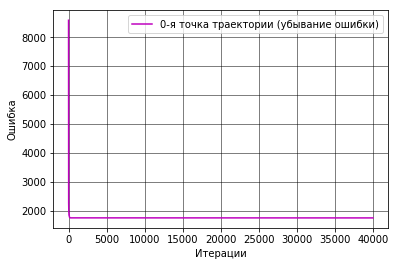

starting at Q: [-0.4996627   1.9631543  -3.6871698   1.5707964  -0.51350856  0.        ] loss: 3.4028235e+38
Steps 40001.0
bestQ: -28.685, 110.029, -484.711, 90.000, -29.562, 0.000
bestLoss: 
[[1104.9999 ]
 [-244.99995]
 [1000.0003 ]]
1745.1554


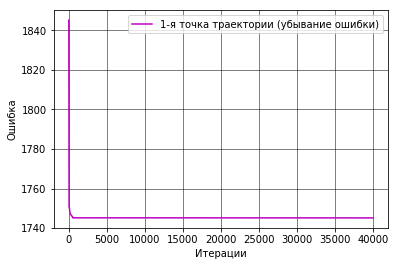

starting at Q: [-0.5006394  1.9203727 -3.7474098  1.5707964 -0.515948   0.       ] loss: 3.4028235e+38
Steps 40001.0
bestQ: -28.637, 108.435, -486.171, 90.000, -29.442, 0.000
bestLoss: 
[[1104.9999 ]
 [-245.00002]
 [ 950.     ]]
1745.155


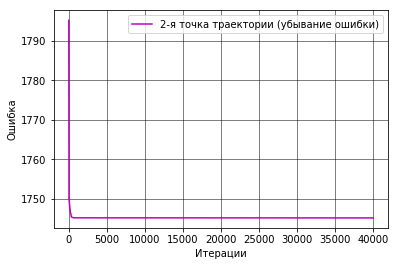

starting at Q: [-0.49980438  1.8925412  -3.7728922   1.5707964  -0.5138617   0.        ] loss: 3.4028235e+38
Steps 40001.0
bestQ: -28.520, 106.600, -487.446, 90.000, -29.151, 0.000
bestLoss: 
[[1105.     ]
 [-244.99994]
 [ 899.99994]]
1745.1552


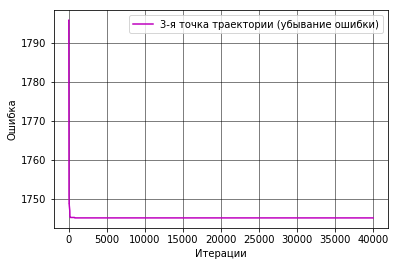

starting at Q: [-0.4977677   1.860527   -3.7951422   1.5707964  -0.50878495  0.        ] loss: 3.4028235e+38
Steps 40001.0
bestQ: -28.337, 104.520, -488.521, 90.000, -28.697, 0.000
bestLoss: 
[[1104.9999 ]
 [-244.99995]
 [ 849.99994]]
1745.1552


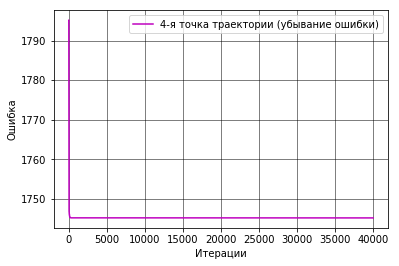

starting at Q: [-0.49457553  1.8242264  -3.8139164   1.5707964  -0.5008583   0.        ] loss: 3.4028235e+38
Steps 40001.0
bestQ: -28.088, 102.195, -489.386, 90.000, -28.081, 0.000
bestLoss: 
[[1105.     ]
 [-245.00014]
 [ 800.     ]]
1745.155


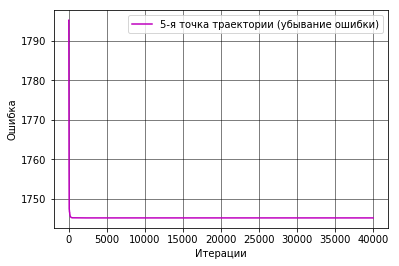

starting at Q: [-0.49022484  1.7836399  -3.8290136   1.5707964  -0.49011382  0.        ] loss: 3.4028235e+38
Steps 40001.0
bestQ: -27.765, 99.635, -490.034, 90.000, -27.289, 0.000
bestLoss: 
[[1105.0001 ]
 [-244.99982]
 [ 749.9999 ]]
1745.1553


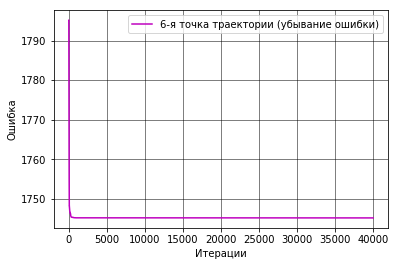

starting at Q: [-0.4845878   1.7389604  -3.8403184   1.5707964  -0.47629097  0.        ] loss: 3.4028235e+38
Steps 40001.0
bestQ: -27.368, 96.849, -490.457, 90.000, -26.325, 0.000
bestLoss: 
[[1105.    ]
 [-245.    ]
 [ 700.0007]]
1745.1555


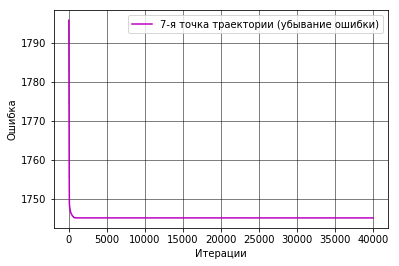

starting at Q: [-0.47766423  1.6903386  -3.8476942   1.5707964  -0.45945552  0.        ] loss: 3.4028235e+38
Steps 40001.0
bestQ: -26.901, 93.847, -490.647, 90.000, -25.201, 0.000
bestLoss: 
[[1105.     ]
 [-245.00005]
 [ 649.9999 ]]
1745.1552


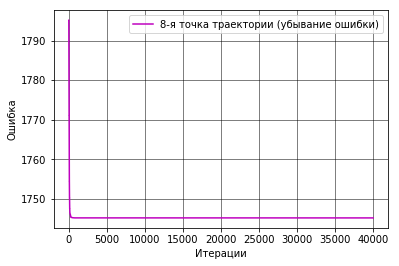

starting at Q: [-0.4695194   1.6379355  -3.8510242   1.5707964  -0.43984208  0.        ] loss: 3.4028235e+38
Steps 40001.0
bestQ: -26.369, 90.641, -490.603, 90.000, -23.933, 0.000
bestLoss: 
[[1105.     ]
 [-244.99997]
 [ 600.     ]]
1745.155


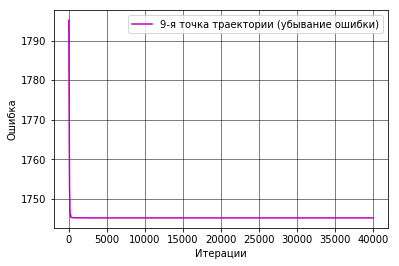

starting at Q: [-0.46022916  1.5819865  -3.850246    1.5707964  -0.41770607  0.        ] loss: 3.4028235e+38
Steps 40001.0
bestQ: -25.781, 87.245, -490.320, 90.000, -22.548, 0.000
bestLoss: 
[[1104.9999 ]
 [-244.99995]
 [ 550.     ]]
1745.155


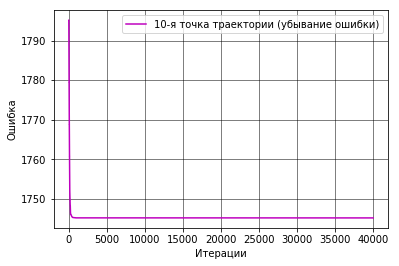

starting at Q: [-0.44996968  1.5227051  -3.845318    1.5707964  -0.39353073  0.        ] loss: 3.4028235e+38
Steps 40001.0
bestQ: -25.209, 84.041, -489.865, 90.000, -21.213, 0.000
bestLoss: 
[[1105.    ]
 [-245.    ]
 [ 504.9999]]
1745.155


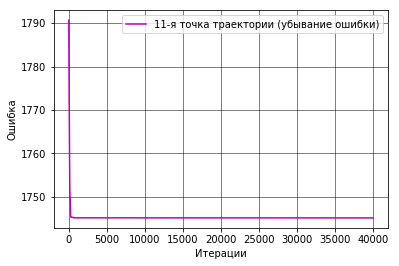

Wall time: 25min 22s


In [10]:
%%time

STEPS_IN_EPOCH = 2000
MAX_EPOCHS = 20
DECAY_PRECISION = 0.0009
bestq1_print = []
bestq2_print = []
bestq3_print = []
bestq4_print = []
bestq5_print = []
bestq6_print = []

traceLoss = []

trajX = []
trajY = []
trajZ = []
trajCount = 0


obobq1 = []
obobq2 = []
obobq3 = []
obobq4 = []
obobq5 = []
obobq6 = []
obobqCount = 0


with tf.Session() as session:
    session.run(model)
    i = 0
    for t in trajectory:
        traceX = []
        traceY = []
        
        session.run(next_target,feed_dict={targetPlace:t})
        
        print("starting at", "Q:", session.run(Q0), "loss:", session.run(best_loss))
        
        while session.run(best_loss) >= 0.04:
            step = session.run(global_step)
            e = session.run(epoch)
            curStep=step+STEPS_IN_EPOCH*(e-1)
            session.run(train)
            decay = session.run(error_decay)
            session.run(new_best_loss)

            if step > STEPS_IN_EPOCH:
                if session.run(epoch) >= MAX_EPOCHS:
                    break

                session.run(new_epoch)
                session.run(reset_step)
            
            if trajCount%500 == 0:
                traj = session.run(xyz)
                trajX.append(traj[0])
                trajY.append(traj[1])
                trajZ.append(traj[2])
            
            trajCount = trajCount + 1
            
            if obobqCount%500 == 0:
                obobq = session.run(best_q)
                obobq1.append(obobq[0]/r)
                obobq2.append(obobq[1]/r)
                obobq3.append((obobq[2]-270*r + 360*r)/r)
                obobq4.append(obobq[3]/r)
                obobq5.append(obobq[4]/r)
                obobq6.append(obobq[5]/r)
            
            obobqCount = obobqCount + 1
            
            traceX.append(curStep)
            traceY.append(session.run(best_loss))
            traceLoss.append(session.run(loss))


        print("Steps",curStep)
        session.run(nextQ)
        session.run(reset_step)
        session.run(reset_epoch)
                
        print("bestQ: %.3f, %.3f, %.3f, %.3f, %.3f, %.3f"% tuple(session.run(bestq11)/r))
        print("bestLoss: ")
        print(session.run(xyz))
        print(session.run(best_loss))

        session.run(best_loss_init)


        fig = plt.figure()
        
        ax = fig.gca()
        bestq_print = session.run(bestq11)
        bestq1_print.append(bestq_print[0]/r)
        bestq2_print.append(bestq_print[1]/r)
        bestq3_print.append((bestq_print[2]+270*r)/r)
        bestq4_print.append(bestq_print[3]/r)
        bestq5_print.append(bestq_print[4]/r)
        bestq6_print.append(bestq_print[5]/r)

        ax.plot(traceX, traceY, color="m")

        
        ax.set_xlabel("Итерации")
        ax.set_ylabel("Ошибка")
        ax.legend(["%i-я точка траектории (убывание ошибки)" % i])
        ax.grid(color='black', linestyle='-', linewidth=0.5)
            
        plt.show()
        i = i + 1

In [11]:
df = DataFrame({'qr1': obobq1, 'qr2' : obobq2, 'qr3': obobq3, 'qr4': obobq4, 'qr5': obobq5, 'qr6': obobq6, 'X': trajX,
                'Y': trajY, 'Z': trajZ})
df.to_excel('testt111adagrad.xlsx', sheet_name='sheet1', index=False)

In [12]:
df = DataFrame({'qb1': bestq1_print, 'qb2' : bestq2_print, 'qb3': bestq3_print, 'qb4': bestq4_print, 'qb5': bestq5_print,
                'qb6': bestq6_print})
df.to_excel('testadagrad.xlsx', sheet_name='sheet1', index=False)

ValueError: setting an array element with a sequence.

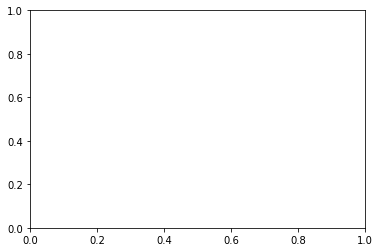

In [95]:
import pylab
import numpy

def makeData():
    target = [-10, 10, 1/2]
    xyz = [-10, 10, 1/2]

    xgrid, ygrid = numpy.meshgrid(target, xyz)

    zgrid = loss
    return xgrid, ygrid, zgrid
    

if __name__ == '__main__':
    target, xyzy, z = makeData()
    pylab.contour(target, xyz, z)

    pylab.show()